In [631]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import sympy


import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, plot

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia as has

# 1 Strain Model

Build SAM and calculate strains

Make the semi-analytic model object.

In [632]:
dur = 10.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
sam = holo.sam.Semi_Analytic_Model() 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains.

In [633]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 5, params = False) 
print(hc_ss.shape)

20:46:06 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
20:46:06 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
20:46:06 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
20:46:06 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
20:46:13 INFO : Scatter added after 6.743877 sec [sam.py:static_binary_density]
20:46:13 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
20:46:13 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
20:46:13 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
20:46:14 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
20:46:14 INFO : stalled binaries are not being accounted for in

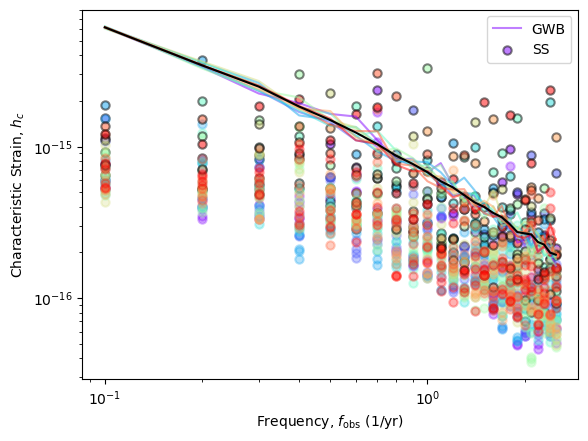

In [634]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_bg = 'GWB'
    else:
        label_bg = None
    plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg, color=colors[rr])
    for ll in range(len(hc_ss[0,0])):
        if ll ==0:
            edgecolor='k'
            alpha_ss = 0.5
            if(rr==0):
                label_ss = 'SS'
            else:
                label_ss = None
        else:
            edgecolor=None
            alpha_ss = 0.3
            label_ss=None
        plt.scatter(fobs*YR, hc_ss[:,rr,ll], alpha=alpha_ss, label=label_ss,
                    color=colors[rr], edgecolors=edgecolor, linewidths=1.5)
plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
plt.legend()


In [635]:
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# # example 5
# dur = 10.0*YR
# cad = .2*YR

# 2 Pulsar Setup
## 2.1 Make pulsars with hasasia

In [636]:
num = 20
phis = np.random.uniform(0, 2*np.pi, size = num)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = num)
# sim uses dur in yrs and cad in #/yr
# make list of hasasia.Pulsar objects
pulsars = hsim.sim_pta(timespan = dur/YR, cad = 1/(cad/YR), sigma = 1e-7,
                      phi = phis, theta = thetas)
print(pulsars[0].__dict__.keys())

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])


In [637]:
print(thetas)
print(phis)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]
[4.32652968 0.52086954 4.43445855 3.76835848 4.30934635 0.80516496
 1.69090516 3.35784329 0.82908667 1.20876628 1.77424731 5.99635359
 2.10644878 4.74253661 5.58552327 2.14840847 1.58783884 4.56560429
 0.43619518 5.54127828]


Make spectra

In [638]:
spectra = []

for pul in pulsars:
    spec = hsen.Spectrum(pul, freqs=fobs) # spectrum object
    spec.NcalInv # calculate inverse noise weighted transmission function along the way
    spectra.append(spec)
    # add white noise and add red noise here? 
    # add_noise_power(noise)
    # add_red_noise_power(A=None, gamma=None, vals=False)
    # add_white_noise_power(sigma=None, dt = None, vals=False)

## 2.2 Overlap Reduction Function

Using Rosado eq.s:
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} $$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

In [639]:
def gammaij_from_thetaij(theta_ij):
    """ Calcualte gamma_ij for two pulsars of relative angle theta_ij.
    
    Parameters
    ----------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsars.

    Returns
    -------
    gamma_ij : scalar 
        [1 - cos(theta_ij)]/2

    """
    return (1-np.cos(theta_ij))/2


def dirac_delta(i,j):
    """ Calculate the dirac delta function of i,j.
    Parameters
    ----------
    i : int
    j : int

    Returns
    ------- 
    dirac_ij : int
        Dirac delta function of i and j

    """
    if(i==j): return 1
    else: return 0

def relative_angle(theta_i, phi_i, theta_j, phi_j):
    """ Calculate relative angle between two pulsars i and j.
    
    Parameters
    ----------
    theta_i : scalar 
        Polar angular position in the sky of the ith pulsar.
    phi_i : scalar
        Azimuthal angular position in the sky of the ith pulsar.
    theta_j : scalar 
        Polar angular position in the sky of the jth pulsar.
    phi_j : scalara
        Azimuthal angular position in the sky of the jth pulsar.

    Returns
    -------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsar.

    """
    
    theta_ij = np.arccos(np.cos(phi_i)*np.cos(phi_j) 
                      + np.sin(phi_i)*np.sin(phi_j)*np.cos(theta_i - theta_j))
    
    return theta_ij

def orf_ij(i, j, theta_ij):
    """ Calculate the overlap reduction function Gamma_i,j as a function of theta_i, theta_j, i, and j.
    
    Parameters
    ----------
    i : int
        index of the ith pulsar
    j : int
        index of the jth pulsar
    theta_ij : scalar
        relative angular position between the ith and jth pulsars

    Returns
    -------
    Gamma : scalar
        The overlap reduction function of the ith and jth pulsars.


    Follows Rosado et al. 2015 Eq. (24)
    """
    dirac_ij = dirac_delta(i, j)
    gamma_ij = gammaij_from_thetaij(theta_ij)
    
    Gamma = (3/2 * gamma_ij *np.log(gamma_ij)
            - 1/4 * gamma_ij
            + 1/2 + dirac_ij)
    if(np.isnan(Gamma) and i!=j):
        print('Gamma_%d,%d is nan, set to 0' % (i,j))
        return 0
    return Gamma


def orf_all(pulsars):
    """ Calculate the overlap reduction function matrix Gamma for a list of hasasia.Pulsar objects

    Paramters
    ---------
    pulsars : (P,) list of hasasia.Pulsar objects.

    Returns
    -------
    Gamma : (P,P) NDarray
        Overlap reduction function matrix for all pulsars i,j with j>i
        Only for j>1, 0 for j<=i

    """

    Gamma = np.zeros((len(pulsars), len(pulsars)))
    for ii in range(len(pulsars)):
        for jj in range(len(pulsars)):
            if (jj>ii): # 0 otherwise, allows sum over all
                # calculate angle between two vectors.
                theta_ij =  relative_angle(pulsars[ii].theta, pulsars[ii].phi,
                                           pulsars[jj].theta, pulsars[jj].phi)
                print('theta_ij', theta_ij)
                # find ORF
                Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)
    
    return Gamma


In [640]:
Gamma = orf_all(pulsars)
print(Gamma)

theta_ij 2.477525167147507
theta_ij 0.10792886649973561
theta_ij 0.5581712021075907
theta_ij 0.017183333069363278
theta_ij 2.7618205864264507
theta_ij 2.635624522361444
theta_ij 0.96868639386163
theta_ij 2.785742295574624
theta_ij 3.117763400388366
theta_ij 2.5522823651715054
theta_ij 1.6698239103318686
theta_ij 2.2200808978813638
theta_ij 0.4160069266016653
theta_ij 1.2589935943234334
theta_ij 2.178121205686884
theta_ij 2.7386908390146107
theta_ij 0.239074609289026
theta_ij 2.3928508081051194
theta_ij 1.214748603920908
theta_ij 2.3695963006477707
theta_ij 3.0356963692550982
theta_ij 2.4947085002168694
theta_ij 0.28429541927894425
theta_ij 1.1700356176706357
theta_ij 2.8369737461704494
theta_ij 0.30821712842711746
theta_ij 0.6878967396437128
theta_ij 1.2533777748605741
theta_ij 0.8077012568156384
theta_ij 1.5855792421507158
theta_ij 2.061518240545842
theta_ij 1.2185315728240735
theta_ij 1.6275389343451956
theta_ij 1.0669693010174688
theta_ij 2.238450557858481
theta_ij 0.084674359042387

Using hasasia.GWBSensitivityCurve

In [641]:
scGWB = hsen.GWBSensitivityCurve(spectra) # orf='hd'
print(scGWB.__dict__.keys())
print(scGWB.chiIJ) 

dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ'])
[ 0.12596678  0.47378764  0.18751404  0.49892814  0.20643161  0.17469802
 -0.05136832  0.21158784  0.24982258  0.15006893 -0.13091541  0.03434553
  0.28753097 -0.13753192  0.01900918  0.201173    0.40571991  0.09689473
 -0.12947585  0.08865951  0.24650478  0.13165343  0.37731511 -0.11947382
  0.22162633  0.36163955  0.10074959 -0.13661044  0.02869304 -0.14322463
 -0.02269494 -0.1302361  -0.13771376 -0.08928178  0.04107515  0.48255717
 -0.13813616  0.11479407  0.46651864  0.17973247  0.2023004  -0.09252752
  0.18611017  0.24779341  0.18144137 -0.14576645  0.07373506  0.36173177
 -0.1146632   0.05848995  0.22335856  0.46382207  0.05807826 -0.10213216
  0.1994646   0.240128   -0.01712124  0.29139255  0.23733006  0.15233056
 -0.04562206  0.03724452 -0.13227959 -0.05371559 -0.09853384 -0.13880364
  0.01988339  0.03459687  0.23874683 -0.10956147  0.21016495  0.16983724
 -0.0

## 2.3 Noise spectral density $P_i$ 
$$ P_i = 2 \Delta t \sigma_i^2 $$

In [642]:
def _white_noise(delta_t, sigma_i):
    """ Calculate the white noise for a given pulsar 2 /Delta t sigma_i^2
    
    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigma_i : scalar
        Error/stdev/variance? for the ith pulsar, in seconds.

    Returns
    -------
    P_i : scalar
        Noise spectral density for the ith pulsar, for bg detection.
        For single source detections, the noise spectral density S_i must also 
        include red noise from all but the loudest single sources, S_h,rest. 
        Rosado et al. 2015 Eq. (23)

    """
    P_i = 2 * delta_t * sigma_i**2
    return P_i

In [643]:
sigmas = np.zeros(num)
for ii in range(num):
    sigmas[ii] = np.mean(pulsars[ii].toaerrs)
noise = _white_noise(cad, sigmas) 
print('P_i =', noise, 's^3 =', noise/YR**3,' yrs^3')

P_i = [1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07] s^3 = [4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30]  yrs^3


# 3 Background Signal
## 3.1 Power Spectral Density
$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

In [644]:
def power_spectral_density(hc_bg, freqs):
    """ Calculate the spectral density S_h(f_k) ~ S_h0(f_k) at the kth frequency

    Parameters
    ----------
    hc_bg : (F,) 1D array of scalars
        Characteristic strain of the background at each frequency. 
    freqs : (F,) 1Darray of scalars
        Frequency bin centers corresponding to each strain

    Returns
    -------
    S_h : (F,) 1Darray of scalars
        Actual (S_h) or ~construction (S_h0) value of the background spectral density. 
        In units of [freqs]^-3
    """

    S_h = hc_bg**2 / (12 * np.pi**2 * freqs**3)
    return S_h

In [645]:
Sh_bg = power_spectral_density(hc_bg[:,0], fobs) # spectral density of bg, using 0th realization
Sh0_bg = Sh_bg # appropsimation used in Rosado et al. 2015
print(Sh_bg)
print(scGWB.S_eff)

[9.95093219e-06 3.72082308e-07 4.93065248e-08 1.55304744e-08
 5.72327710e-09 3.05808330e-09 9.35980237e-10 3.54686262e-10
 2.06508213e-10 1.21714440e-10 1.20310383e-10 4.69242665e-11
 2.54497120e-11 1.55757853e-11 1.26614036e-11 8.07831945e-12
 5.88293768e-12 4.51260868e-12 2.08169993e-12 1.92983547e-12
 1.95919114e-12 1.03445751e-12 1.03829775e-12 7.36795318e-13
 4.46819959e-13]
[2.15267894e-22 2.40501283e-22 5.04087044e-22 8.80015703e-22
 1.36800752e-21 1.97388311e-21 2.71801098e-21 3.69611403e-21
 6.08711282e-21 2.39458452e+09 9.11221400e-21 8.30200126e-21
 9.33438499e-21 1.06670378e-20 1.21616980e-20 1.37855220e-20
 1.55272224e-20 1.73820441e-20 1.93477273e-20 4.34856304e-20
 2.36077097e-20 2.59012401e-20 2.83037593e-20 3.08155128e-20
 3.34369713e-20]


## 3.2 mu_1
$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} $$


In [646]:
def mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    mu_1B = 0
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    mu_1B += ((Gamma_ij**2 * Sh * Sh0)
                            /((P_i+Sh0) * (P_j+Sh0) 
                                + Gamma_ij**2 * Sh0**2))
    mu_1B *= 2
    return mu_1B

def mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for jj>ii, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    
    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis] **2 
            * Sh_bg[np.newaxis, np.newaxis, :]
            * Sh0_bg[np.newaxis, np.newaxis, :])
    denom = ((noise[:, np.newaxis, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               * (noise[np.newaxis, :, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis, np.newaxis, :]**2)
    
    # should not need this part if Gamma takes all jj<=ii parts to zero
    sum = np.sum(numer/denom)
    mu_1B = 2*sum
    return mu_1B


In [647]:
mu_1B_loops = mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(mu_1B_loops, mu_1B)

23.777928936904893 23.77792893690488


## 3.3 sigma_0
$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$



In [648]:
def sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        
    
    Follows Eq. (A17) from Rosado et al. 2015.
    """

    sigma_0B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh0 = Sh0_bg[kk]
                    numer = Gamma_ij**2 * Sh0**2 * P_i * P_j
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_0B += (numer/denom)
    
    sigma_0B = np.sqrt(2*sigma_0B)
    return sigma_0B


def sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        

    Follows Eq. (A17) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis])
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_0B = np.sqrt(2*sum)
    return sigma_0B



In [649]:
sigma_0B_loops = sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_0B_loops, sigma_0B)

1.1535052487263455 1.1535052487263462


## 3.4 sigma_1
$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$

In [650]:
def sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    sigma_1B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    numer = (Gamma_ij**2 * Sh0**2 * 
                             ((P_i + Sh) * (P_j + Sh) 
                              + Gamma_ij**2 * Sh**2))
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_1B += (numer/denom)
    
    sigma_1B = np.sqrt(2*sigma_1B)
    return sigma_1B


def sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which mapsimizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * ((noise[:,np.newaxis,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                * (noise[np.newaxis,:,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                + Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2))
             
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_1B = np.sqrt(2*sum)
    return sigma_1B



In [651]:
sigma_1B_loops = sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_1B_loops, sigma_1B)

4.8762617789557705 4.876261778955769


## 3.5 SNR Check
$$S/N_B \equiv \frac{\mu_1}{ \sigma_1} = \Bigg[ 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h^2}{P_iP_j + S_h[P_i + P_j] + S_h^2[1+\Gamma_{ij}^2]}   \Bigg]^{1/2} \quad\quad\quad(\mathrm{A}19)$$

In [652]:
def SNR_bg_B(noise, Gamma, Sh_bg):
    """ Calculate S/N_B for the background, using P_i, Gamma, S_h and S_h0
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    SNR_B : Scalar
        Signal to noise ratio assuming the B statistic
        

    Follows Eq. (A19) from Rosado et al. 2015.
    """


    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2
    denom = (noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis]
             + Sh_bg[np.newaxis,np.newaxis,:] * (noise[:,np.newaxis,np.newaxis]+noise[np.newaxis,:,np.newaxis])
             + Sh_bg[np.newaxis,np.newaxis,:]**2 * (1 + Gamma[:,:,np.newaxis]**2))

    sum = np.sum(numer/denom)
    SNR_B = np.sqrt(2*sum)
    return SNR_B

    

In [653]:
SNR_B = SNR_bg_B(noise, Gamma, Sh_bg)
print(SNR_B, mu_1B/sigma_1B)

4.876261778955769 4.876261778955769


compare to hasasia, where they get SNR as a function of $$S_h = \frac{3H_0^2}{2\pi^2} \frac{\Omega_\mathrm{gw}(f)}{f^3}$$ in units of strain^2/Hz, where $\Omega_{gw}=\frac{2\pi^2}{3\;H_0^2}f^3\;S_I$ 

In [654]:
print(scGWB.Omega_gw.shape)
print(scGWB._H_0.to('Hz'))

(25,)
2.3333610883999426e-18 Hz


In [655]:
def _Sh_hasasia_generic_bg(scGWB):
    """ Calculate the signal strain power spectral density, 
        `Sh` for hasasia's SNR calculation
        
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    Sh_h : (F,) 1Darray
        Sh as used in hasasia's SNR calculation, for each frequency.
    
    """
    freqs = scGWB.freqs
    H0 = scGWB._H_0.to('Hz').value
    Omega_gw = scGWB.Omega_gw
    Sh_h = 3*H0**2 / (2*np.pi**2) * Omega_gw / freqs**3
    return Sh_h

def SNR_hasasia_generic_bg(scGWB):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    SNR_h : scalar
        Signal to noise ratio from hasasia.
    """
    Sh_h = _Sh_hasasia_generic_bg(scGWB)
    SNR_h = scGWB.SNR(Sh_h)
    return SNR_h
    


In [656]:
SNR_hg = SNR_hasasia_generic_bg(scGWB)

print(SNR_hg, SNR_B, mu_1B/sigma_1B) # close enough?

6.928203230275509 4.876261778955769 4.876261778955769


We could also use the real characeristic strains with equation (56)
$$h_c(f) \equiv \sqrt{f S_h(f)}$$
$$S_h(f) = h_c(f)^2/f$$

In [657]:
def _Sh_hasasia_modeled_bg(freqs, hc_bg):
    """ Calculate Sh for hsen.GWBSensitivityCurve.SNR(Sh) from a 
    modeled GWB characteristic strain.
    
    Parameters
    ----------
    freqs : (F,) 1Darray
        Frequencies of char strain.
    hc_bg : (F,R) NDarray
        GWB characteristic strain for each frequency and realization.
    
    Returns
    -------
    Sh_h : (F,R) NDarray
        Sh as used in hasasia's SNR calculation, for each frequency.
    """

    Sh_h = hc_bg**2 / freqs[:,np.newaxis]
    return Sh_h    

def SNR_hasasia_modeled_bg(scGWB, hc_bg):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
    hc_bg : (F,R) NDarray
        Realistic characteristic strain of the background.
        
    Returns
    -------
    SNR_h : (R) 1Darray)
        Signal to noise ratio from hasasia, for each realization.
    """
    Sh_h = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
    SNR_h = np.zeros(len(hc_bg[0]))
    for rr in range(len(hc_bg[0])):
        SNR_h[rr] = scGWB.SNR(Sh_h[:,rr])
    return SNR_h

In [658]:
SNR_hr = SNR_hasasia_modeled_bg(scGWB, hc_bg)
print(SNR_hr)

[55.97258024 55.61758747 56.95125392 57.73759495 54.3788437  57.24128711
 56.09821784 54.9717502  56.86454285 56.39665057 55.06160068 57.2814821
 58.42100985 57.09073423 52.70784948 56.36411249 53.80928868 60.06578839
 54.77417586 55.06172832 55.62035482 58.13283613 53.44725393 58.34179257
 54.39392456 56.28274832 56.00419324 55.41824955 58.38906777 53.68544622]


compare Sh generic and Sh realistic, these look reasonably close

In [659]:
Sh_hg = _Sh_hasasia_generic_bg(scGWB)
Sh_hr = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
print('hasasia generic Sh',  Sh_hg.shape, 
      '\n', Sh_hg)
print('modeled Sh, averaged over realizations', Sh_hr.shape, 
      '\n', np.mean(Sh_hr, axis=1))

hasasia generic Sh (25,) 
 [2.15267894e-22 2.40501283e-22 5.04087044e-22 8.80015703e-22
 1.36800752e-21 1.97388311e-21 2.71801098e-21 3.69611403e-21
 6.08711282e-21 2.39458452e+09 9.11221400e-21 8.30200126e-21
 9.33438499e-21 1.06670378e-20 1.21616980e-20 1.37855220e-20
 1.55272224e-20 1.73820441e-20 1.93477273e-20 4.34856304e-20
 2.36077097e-20 2.59012401e-20 2.83037593e-20 3.08155128e-20
 3.34369713e-20]
modeled Sh, averaged over realizations (25, 30) 
 [1.18295373e-20 1.87633796e-21 6.42268486e-22 2.75173569e-22
 1.42458999e-22 8.37825544e-23 4.96266850e-23 3.12422940e-23
 2.11223319e-23 1.45608207e-23 1.08024736e-23 7.84118004e-24
 5.90537496e-24 4.33661779e-24 3.37748212e-24 2.75730964e-24
 2.43396032e-24 1.69934474e-24 1.28625771e-24 1.10981646e-24
 1.04372009e-24 8.14660859e-25 7.04663907e-25 5.56252811e-25
 4.82528956e-25]


most look reasonably close, but no idea why the generic gives a really high Sh at just one frequency.

In [660]:
print('Rosado modeled:', SNR_B)
print('hasasia modeled:', SNR_hr)
print('hasasia generic:', SNR_hg)

Rosado modeled: 4.876261778955769
hasasia modeled: [55.97258024 55.61758747 56.95125392 57.73759495 54.3788437  57.24128711
 56.09821784 54.9717502  56.86454285 56.39665057 55.06160068 57.2814821
 58.42100985 57.09073423 52.70784948 56.36411249 53.80928868 60.06578839
 54.77417586 55.06172832 55.62035482 58.13283613 53.44725393 58.34179257
 54.39392456 56.28274832 56.00419324 55.41824955 58.38906777 53.68544622]
hasasia generic: 6.928203230275509


## 3.6 Detection Probability
$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big]

In [661]:
ALPHA0 = 0.001 # false alarm probability (FAP)

def bg_detection_probability(sigma_0, sigma_1, mu_1, alpha_0):
    """ Calculate the background detection probability, gamma_bg.

    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of stochastic noise processes.
    sigma_1 : scalar
        Standard deviation of GWB PDF.
    mu_1 : scalar
        Mean of GWB PDF.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    dp_bg : scalar
        Background detection probability.

        
    Follows Rosado et al. 2015 Eq. (15)
    """
    temp = ((np.sqrt(2) * sigma_0 * sp.special.erfcinv(2*alpha_0) - mu_1)
            /(np.sqrt(2) * sigma_1))
    dp_bg = .5 * sp.special.erfc(temp)
    return dp_bg

In [662]:
dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)
print(dp_bg)

0.9999830279270818


In [663]:
def detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg, return_all = False):
    """ Calculate the background detection probability, and all intermediary steps.

    Parameters
    ----------
    THETAS : (P,) 1Darray of scalars
        Latitudinal angular position of each pulsar in radians.
    PHIS: (P,) 1Darray of scalars
        Longitudinal angular position of each pulsar in radians.
    SIGMAS : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    return_all : Bool
        Whether to return all parameters or just dp_bg

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar

    """
    # Overlap Reduction Function
    num = len(THETAS) # number of pulsars, P
    Gamma = np.zeros((num, num)) # (P,P) 2Darray of scalars, Overlap reduction function between all puolsar
    for ii in range(num):
        for jj in range(num):
            theta_ij =  relative_angle(THETAS[ii], PHIS[ii],
                                        THETAS[jj], PHIS[jj])
            # find ORF
            Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)

    # Spectral Density
    Sh_bg = power_spectral_density(hc_bg[:], fobs) # spectral density of bg, using 0th realization
    Sh0_bg = Sh_bg # appropsimation used in Rosado et al. 2015

    # Noise 
    noise = _white_noise(cad, SIGMAS) 

    mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)

    if(return_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg

# Full Walkthrough

In [664]:
# # example 5
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# dur = 10.0*YR
# cad = .2*YR

Print Info

In [665]:
# num_pulsars = 40
# THETAS = np.random.uniform(0.001, 2*np.pi, num_pulsars) # (P,) 1Darray of scalars, angular sky position of each pulsar
# PHIS = np.random.uniform(0.001, np.pi, num_pulsars)
# SIGMAS = np.random.uniform(1e-6, 2e-6, num_pulsars) # (P,) 1Darray of scalars, sigma_i of each pulsar
# ALPHA0 = 0.001
# dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B = \
#     detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg[:,1], return_all=True)
# print('Number of pulsars:',num_pulsars)
# print('\nOVERLAP')
# print('thetas (pi):\t%s' % str(holo.utils.stats(THETAS/np.pi)))
# print('Gamma:\t%s' % str(holo.utils.stats(Gamma)))
# # print('Gamma:\t', Gamma)

# print('\nNOISE')
# print('cadence (s): \t%.2e' % cad)
# print('sigmas (s): %s', str(holo.utils.stats(SIGMAS)))
# print('P_i (s^3):\t%s' % str(holo.utils.stats(noise)))

# print('\nSIGNAL')
# print('fobs (nHz): \t%s' % str(holo.utils.stats(fobs*10**9)))
# print('hc_bg:   \t%s' % str(holo.utils.stats(hc_bg[:,0])))
# print('S_h (s^3):\t%s' % str(holo.utils.stats(Sh_bg)))

# print('\nB STATISTICS')
# print('sigma_0: \t%.2e' % sigma_0B)
# print('sigma_1: \t%.2e' % sigma_1B)
# print('mu_1:    \t%.2e' % mu_1B)

# print('\nDETECTION PROB')
# print('DP_bg:   \t%.2e' % dp_bg)
# print('SNR_B:   \t%.2f' % (mu_1B/sigma_1B))

Compare to hasasia

In [666]:
# scGWB = hsen.GWBSensitivityCurve(spectra)

In [667]:
# # print(Sh_bg)
# print('pulsars:', pulsars[0].__dict__.keys())
# print('spectra:', spectra[0].__dict__.keys())
# print('scGWB:', scGWB.__dict__.keys())
# print(scGWB.S_eff)

## detect_bg_pta(pulsars)
can I get cad from pulsar objects?

In [668]:
# NOTE: Could modify this to take hc_bg[F,R], and return dp[R]

def detect_bg_pta(pulsars, spectra, cad, hc_bg, alpha_0=0.001, ret_all = False):
    """ Calculate the background detection probability, and all the intermediary steps
    from a list of hasasia.Pulsar objects.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    spectra : (P,) list of hasasia.Spectrum objects
        The spectrum for each pulsar.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    alpha_0 : scalar
        Falsa alarm probability
    return_all : Bool
        Whether or not to return intermediate variables.

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar
    """

    # check inputs
    assert len(pulsars) == len(spectra), f"'pulsars ({len(pulsars)}) does not match 'spectra' ({len(spectra)}) !"
    
    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = pulsars[ii].toaerrs

    fobs = spectra[0].freqs

    Gamma = _orf_pta(pulsars)

    Sh_bg = _power_spectral_density(hc_bg[:], fobs)

    white_noise = _white_noise(cad, sigmas)

    mu_1B = _mean1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = _sigma0_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = _sigma1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = _bg_detection_probability(sigma_0B, sigma_1B, mu_1B, alpha_0)

    if(ret_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg
    



In [669]:
print(spectra[0].toaerrs)

[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]


# 4 Single Sources Setup

## 4.1 Place binaries at random positions

(25, 30, 5)


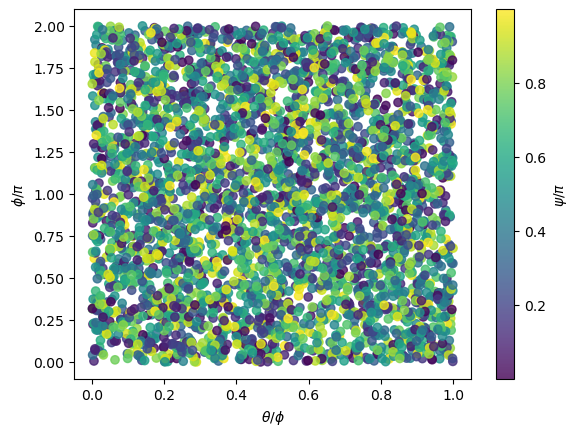

In [670]:
# shape (F,R,L)
ss_thetas = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_phis = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_iotas = np.random.uniform(0, np.pi, size=hc_ss.size).reshape(hc_ss.shape)
# ss_psis = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# ss_psis = np.ones_like(ss_phis)*(0)
ss_psis = ss_iotas
label = 'ss_psis=ss_iotas=random 0 to pi'
ss_Phi0s = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
print(ss_thetas.shape)
plt.scatter(ss_thetas/np.pi, ss_phis/np.pi, c=ss_psis/np.pi, cmap='viridis', alpha=0.8)
plt.xlabel(r'$\theta/\phi$')
plt.ylabel('$\phi/\pi$')
plt.colorbar(label=r'$\psi/\pi$ ')

## 4.2 Unitary vectors

$$\hat{m} = +[\sin (\phi)\cos(\psi) - \sin (\psi) cos(\phi) cos(\theta)] \hat{x} 

- [\cos (\phi) \cos(\psi) + \sin(\psi) \sin(\phi) \cos(\theta)] \hat{y} 

+ [\sin(\psi)\sin(\phi)]\hat{z} \quad\quad\quad(40)$$

$$ \hat{n} = +[-\sin(\phi) \sin(\psi) - \cos(\psi) \cos(\phi) \cos(\theta)] \hat{x} 
+[\cos(\phi) \sin(\psi) - \cos(\psi) \sin(\phi) \cos(\theta)] \hat{y} 
+[\cos(\psi) \sin(\theta)]\hat{z} \quad\quad\quad(41)$$

$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z} \quad\quad\quad(42)$$

These are functions of $\theta$ and $\phi$, the angular position of the binary, and $\psi$, the inclination of the binary. 

In [671]:
def _m_unitary_vector(theta, phi, psi):
    """ Calculate the unitary vector m-hat for the antenna pattern functions.
    
    Parameters
    ----------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    psi : (F,R,L) NDarray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    m_hat : (3,F,R,L) NDarray 
        Unitary vector m-hat with x, y, and z components at 
        index 0, 1, and 2, respectively.
        
    """
    mhat_x = (np.sin(phi) * np.cos(psi) 
              - np.sin(psi) * np.cos(phi) * np.cos(theta))
    mhat_y = -(np.cos(phi) * np.cos(psi)
               + np.sin(psi) * np.sin(phi) * np.cos(theta))
    mhat_z = (np.sin(psi) * np.sin(theta))

    m_hat = np.array([mhat_x, mhat_y, mhat_z])
    return m_hat

def _n_unitary_vector(theta, phi, psi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    psi : (F,R,L) 1Darray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    n_hat : (3,F,R,L) NDarray
        Unitary vector n-hat.
        
    """

    nhat_x = (- np.sin(phi) * np.sin(psi) 
              - np.cos(psi) * np.cos(phi) * np.cos(theta))
    nhat_y = (np.cos(phi) * np.sin(psi) 
              - np.cos(psi) * np.sin(phi) * np.cos(theta))
    nhat_z = np.cos(psi) * np.sin(theta)

    n_hat = np.array([nhat_x, nhat_y, nhat_z])
    return n_hat

def _Omega_unitary_vector(theta, phi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    
    Returns
    -------
    Omega_hat : (3,F,R,L) NDarray
        Unitary vector Omega-hat.
    """

    Omegahat_x = - np.sin(theta) * np.cos(phi)
    Omegahat_y = - np.sin(theta) * np.sin(phi)
    Omegahat_z = - np.cos(theta)

    Omega_hat = np.array([Omegahat_x, Omegahat_y, Omegahat_z])
    return Omega_hat



In [672]:
m_hat = _m_unitary_vector(ss_thetas, ss_phis, ss_psis)
n_hat = _n_unitary_vector(ss_thetas, ss_phis, ss_psis)
Omega_hat = _Omega_unitary_vector(ss_thetas, ss_phis)
print(m_hat.shape, holo.utils.stats(np.sum(m_hat**2, axis=0)), '\n', 
      n_hat.shape, holo.utils.stats(np.sum(n_hat**2, axis=0)), '\n',  
      Omega_hat.shape, holo.utils.stats(np.sum(Omega_hat**2, axis=0))) # should all be 1
print(m_hat.shape, m_hat[:,0,0,0])
print(n_hat.shape, n_hat[:,0,0,0])
print(Omega_hat.shape, Omega_hat[:,0,0,0])

(3, 25, 30, 5) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 25, 30, 5) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 25, 30, 5) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00
(3, 25, 30, 5) [-0.83808442 -0.50323741  0.21063384]
(3, 25, 30, 5) [ 0.49464618 -0.86381426 -0.09565604]
(3, 25, 30, 5) [0.23008621 0.02402138 0.97287374]


Compare to hasasia, using just the 0th realization
* Omega_hat ($\hat{\Omega}$ in Rosado+2015) -> hsky.K ($\hat{k}$ in Hazboun+2019)
* m_hat ($\hat{m}$ in Rosado+2015) -> hsky L ($\hat{l}$ in Hazboun+2019)
* n_hat ($\hat{n}$ in Rosado+2015) -> hsky M ($\hat{m}$ in Hazboun+2019), -M if we use $\pi - \theta$ for colatitude

In [673]:
# compare using just the 0th realization, just the loudest source
# thetas_gw = np.pi - ss_thetas[:,0]  # pi - latitude gives colatitude, which reverses the sign of hsky.M
thetas_gw = ss_thetas[:,0,0] 
phis_gw = ss_phis[:,0,0]
print(len(spectra), thetas_gw.shape, phis_gw.shape)
skymap = hsky.SkySensitivity(spectra, thetas_gw, phis_gw)
ii=2
print('K of 0th freq source:', skymap.K[:,ii],
      '\nL of 0th freq source:', skymap.L[:,ii], 
      '\nM of 0th freq source:', skymap.M[:,ii])
print('\nOmega-hat', Omega_hat[:,ii,0,0],
      '\nm-hat:', m_hat[:,ii,0,0],
      '\nn-hat', n_hat[:,ii,0,0])

20 (25,) (25,)
K of 0th freq source: [ 0.61197115 -0.46217198  0.64178529] 
L of 0th freq source: [0.60266189 0.79799665 0.        ] 
M of 0th freq source: [-0.51214251  0.38677954  0.76688437]

Omega-hat [ 0.61197115 -0.46217198  0.64178529] 
m-hat: [-0.67503221 -0.72806812  0.11936633] 
n-hat [ 0.41209564 -0.5062745  -0.75753767]


Hasasia:
$$\hat{k} = -\sin(\theta) \cos(\phi) \hat{x} - \sin(\theta) \sin(\phi) \hat{y} -\cos(\theta)\hat{z}$$
$$\hat{l} = \sin(\phi)\hat{x} - \cos(\phi)\hat{y} + 0 \hat{z}$$
$$\hat{m} = -\cos(\theta) \cos(\phi) \hat{x} - \cos(\theta)\sin(\phi) \hat{y} + \sin(\theta)\hat{z}$$
Me/Rosado/Sesano:

$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z}$$

$$\hat{m} = +[\sin (\phi)\cos(\psi) - \sin (\psi) cos(\phi) cos(\theta)] \hat{x} 
- [\cos (\phi) \cos(\psi) + \sin(\psi) \sin(\phi) \cos(\theta)] \hat{y} 
+ [\sin(\psi)\sin(\phi)]\hat{z}$$

$$ \hat{n} = +[-\sin(\phi) \sin(\psi) - \cos(\psi) \cos(\phi) \cos(\theta)] \hat{x} 
+[\cos(\phi) \sin(\psi) - \cos(\psi) \sin(\phi) \cos(\theta)] \hat{y} 
+[\cos(\psi) \sin(\theta)]\hat{z}$$
if $\psi=0$ these reduce to:
$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z}$$

$$\hat{m} = +[\sin (\phi)] \hat{x} 
- [\cos (\phi)] \hat{y} 
+ [0]\hat{z}$$

$$ \hat{n} = +[ - \cos(\phi) \cos(\theta)] \hat{x} 
+[-  \sin(\phi) \cos(\theta)] \hat{y} 
+[\sin(\theta)]\hat{z}$$


## 4.3 Pulsar unitary vector
$$ \hat{p}_i = \sin(\theta_i) \cos(\phi_i) \hat{x} + \sin(\theta_i) \sin(\phi_i) \hat{y} + \cos(\theta_i) \hat{z} \quad\quad\quad(43)$$
where $\theta_i$ and $\phi_i$ give the angular position of the ith pulsar.

In [674]:
def _pi_unitary_vector(phi_i, theta_i):
    """ Calculate the unitary vector p_i-hat for the ith pulsar.
    
    Parameters
    ----------
    phi : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    theta : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    Returns
    -------
    pi_hat : (3,P) vector
        pulsar unitary vector
    
    """

    pihat_x = np.sin(theta_i) * np.cos(phi_i)
    pihat_y = np.sin(theta_i) * np.sin(phi_i)
    pihat_z = np.cos(theta_i)

    pi_hat = np.array([pihat_x, pihat_y, pihat_z])
    return pi_hat

In [675]:
pi_hat = _pi_unitary_vector(phis, thetas)
print(holo.utils.stats(np.sum(pi_hat**2, axis=1))) # should all be 1
print(pi_hat.shape, pi_hat[:,0])

7.50e-32, 7.50e-32, 7.50e-32, 7.30e+00, 1.27e+01, 1.27e+01, 1.27e+01
(3, 20) [-3.76355397e-01 -9.26475372e-01  6.12323400e-17]


## 4.4 Antenna Pattern Functions
$$ F_i^+ = \frac{1}{2}  \frac{[\hat{m}\cdot \hat{p}_i]^2 -[ \hat{n} \cdot \hat{p}_i]^2}{1  + \hat{\Omega} \cdot \hat{p}_i} \quad\quad(38)$$
 
 $$ F_i^\times = \frac{[\hat{m} \cdot \hat{p}_i] [\hat{n} \cdot \hat{p}_i]}{1 + \hat{\Omega} \cdot \hat{p}_i} \quad\quad(39)$$

In [676]:
def dotprod(vec1, vec2):
    """ Calculate the dot product for NDarrays of 3D vectors, with
     vector elements specified by the first index. 
     
     Parameters
     ----------
     vec1 : (3,N1,N2,N3,...N) NDarray
     vec2 : (3,N1,N2,N3,...N) NDarray

     Returns
     -------
     dotted : (N1,N2,N3,...N) NDarray
        The dot product of the vectors specified by the first dimension,
        for every N1, N2, N3,...N.

    Example: find the dot product of 3D vectors for every P,F,R, using NDarrays
    of shape (3,P,F,R)
     """
    
    dotted = vec1[0,...]*vec2[0,...] + vec1[1,...]*vec2[1,...] + vec1[2,...]*vec2[2,...]
    return dotted


def _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat):
    """ + antenna pattern function for the ith pulsar.
    
    Parameters
    ----------
    m_hat : (3,F,R,L) NDarray
        Single source m_hat unitary vector for each frequency and realization.
    n_hat : (3,F,R,L) NDarray
        Single source mnhat unitary vector for each frequency and realization.
    Omega_hat : (3,F,R,L) NDarray
        Single source Omega_hat unitary vector for each frequency and realization.
    pi_hat : (3,P) NDarray
        Pulsar term unitary vector for the ith pulsar.
        
    Returns
    -------
    F_iplus : (P,F,R,L) NDarray
        Plus antenna pattern function for each pulsar and binary of each realization.
    F_icross : (P,F,R,L) NDarray
        Cross antenna pattern function for each pulsar and binary of each realization. 
    
    """
    mh = m_hat[:,np.newaxis,:,:]
    nh = n_hat[:,np.newaxis,:,:]
    Oh = Omega_hat[:,np.newaxis,:,:]
    ph = pi_hat[:,:,np.newaxis,np.newaxis,np.newaxis]
    denom = 1 + dotprod(Oh, ph)
    F_iplus = ((dotprod(mh, ph)**2 - dotprod(nh, ph)**2) 
               / denom / 2)
    F_icross = dotprod(mh, ph) * dotprod(nh, ph) / denom
    
    return F_iplus, F_icross
    

In [677]:
F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat)
print(F_iplus.shape, holo.utils.stats(F_iplus))
print(F_icross.shape, holo.utils.stats(F_icross))

(20, 25, 30, 5) -9.99e-01, -6.54e-01, -4.16e-01, 5.58e-03, 4.29e-01, 6.62e-01, 9.98e-01
(20, 25, 30, 5) -9.98e-01, -6.56e-01, -4.19e-01, 4.01e-04, 4.23e-01, 6.66e-01, 1.00e+00


Compare to hasasia, using just the 0th realization
* $F_{i,\mathrm{plus}}$ ~> skymap.Fplus
* $F_{i,\mathrm{cross}}$ ~> -, reversed skymap.Fcross

These don't correspond exactly, but are closeish idk

In [678]:
print('SORTED')
print(skymap.Fplus.shape)
print(skymap.Fcross.shape)
# 0th frequency, 0th realization, 0th loudest, all pulsars
print('skymap.Fplus\n', np.sort(skymap.Fplus[:,0]))
print('F_iplus\n', np.sort(F_iplus[:,0,0,0]))
# print('skymap.Flong', skymap.Flong)
# print('skymap.Fbreathe', skymap.Fbreathe)


print('skymap.Fcross\n', np.sort(skymap.Fcross[:,0]))
print('F_icross\n', np.sort(F_icross[:,0,0,0]))


SORTED
(20, 25)
(20, 25)
skymap.Fplus
 [-0.50329155 -0.50193661 -0.50161459 -0.48294933 -0.46685538 -0.39920854
 -0.3649903  -0.33265321 -0.31928567 -0.30472003 -0.27489717 -0.06255439
 -0.02517818  0.03852907  0.0579866   0.25893123  0.27348391  0.28847692
  0.30339828  0.59865513]
F_iplus
 [-0.55130388 -0.54836225 -0.40435445 -0.35640514 -0.34191064 -0.33191262
 -0.27633103 -0.25565464 -0.12036314 -0.03260705  0.01458218  0.08548776
  0.13118782  0.14981294  0.33529991  0.34500486  0.38495058  0.39423565
  0.4998008   0.58616233]
skymap.Fcross
 [-0.52635226 -0.46526466 -0.45325866 -0.41162777 -0.40751206 -0.36824591
 -0.3537737  -0.29728235 -0.24814855 -0.24609016 -0.14058502 -0.08253785
 -0.07285595  0.01570345  0.09835134  0.2823097   0.40928412  0.41866043
  0.41879697  0.44145111]
F_icross
 [-0.39170014 -0.35826146 -0.2566298  -0.22839655 -0.06651265 -0.04001591
  0.00065689  0.00550057  0.1291486   0.22449983  0.24185923  0.31322648
  0.36737026  0.41796322  0.42690928  0.439791

In [679]:
print(skymap.Fplus.shape)
print(skymap.Fcross.shape)
# 0th frequency, 0th realization, 0th loudest, all pulsars
print('skymap.Fplus\n', (skymap.Fplus[:,0]))
print('F_iplus\n', (F_iplus[:,0,0,0]))
# print('skymap.Flong', skymap.Flong)
# print('skymap.Fbreathe', skymap.Fbreathe)


print('skymap.Fcross\n', (skymap.Fcross[:,0]))
print('F_icross\n', (F_icross[:,0,0,0]))


(20, 25)
(20, 25)
skymap.Fplus
 [-0.31928567  0.25893123 -0.39920854  0.28847692 -0.30472003  0.0579866
 -0.50161459  0.59865513  0.03852907 -0.27489717 -0.50193661  0.27348391
 -0.3649903  -0.50329155 -0.02517818 -0.33265321 -0.48294933 -0.46685538
  0.30339828 -0.06255439]
F_iplus
 [ 0.13118782  0.39423565  0.01458218  0.58616233  0.14981294  0.34500486
 -0.34191064  0.4998008   0.33529991  0.08548776 -0.40435445 -0.03260705
 -0.54836225 -0.27633103 -0.33191262 -0.55130388 -0.25565464 -0.12036314
  0.38495058 -0.35640514]
skymap.Fcross
 [-0.45325866 -0.29728235 -0.36824591 -0.52635226 -0.46526466 -0.40751206
  0.01570345 -0.14058502 -0.41162777 -0.3537737   0.09835134  0.2823097
  0.40928412 -0.07285595  0.41879697  0.44145111 -0.08253785 -0.24814855
 -0.24609016  0.41866043]
F_icross
 [ 0.53868034  0.00065689  0.54291792  0.1291486   0.53561328  0.22449983
  0.36737026 -0.35826146  0.24185923  0.439791    0.31322648 -0.39170014
  0.00550057  0.42690928 -0.2566298  -0.04001591  0.417

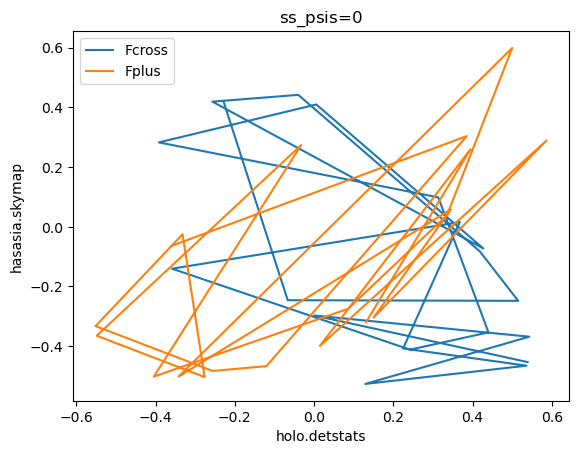

In [680]:
plt.title('ss_psis=$0$')
plt.plot(F_icross[:,0,0,0], 
         skymap.Fcross[:,0], label='Fcross')
plt.plot(F_iplus[:,0,0,0],
         skymap.Fplus[:,0], label='Fplus')
plt.xlabel('holo.detstats')
plt.ylabel('hasasia.skymap')
plt.legend()

What if I use the hasasia unitary vectors with my antenna pattern function

In [681]:
print(m_hat.shape, skymap.L.shape)

(3, 25, 30, 5) (3, 25)


In [682]:
F_iplus3, F_icross3 = _antenna_pattern_functions(skymap.L[...,np.newaxis,np.newaxis], 
                                                 skymap.M[...,np.newaxis,np.newaxis], 
                                                 skymap.K[...,np.newaxis,np.newaxis], 
                                                 pi_hat)

In [683]:
print(skymap.Fplus.shape)
print(skymap.Fcross.shape)
# 0th frequency, 0th realization, 0th loudest, all pulsars
print('skymap.Fplus\n', np.sort(skymap.Fplus[:,0]))
print('skymap.Fcross\n', np.sort(skymap.Fcross[:,0]))
# print('skymap.Flong', skymap.Flong)
# print('skymap.Fbreathe', skymap.Fbreathe)


# print('F_icross\n', np.sort(F_icross[:,0,0,0]))
# print('F_iplus\n', np.sort(F_iplus[:,0,0,0]))

print('F_iplus3\n', np.sort(F_iplus3[:,0,0,0]))
print('F_icross3\n', np.sort(F_icross3[:,0,0,0]))

(20, 25)
(20, 25)
skymap.Fplus
 [-0.50329155 -0.50193661 -0.50161459 -0.48294933 -0.46685538 -0.39920854
 -0.3649903  -0.33265321 -0.31928567 -0.30472003 -0.27489717 -0.06255439
 -0.02517818  0.03852907  0.0579866   0.25893123  0.27348391  0.28847692
  0.30339828  0.59865513]
skymap.Fcross
 [-0.52635226 -0.46526466 -0.45325866 -0.41162777 -0.40751206 -0.36824591
 -0.3537737  -0.29728235 -0.24814855 -0.24609016 -0.14058502 -0.08253785
 -0.07285595  0.01570345  0.09835134  0.2823097   0.40928412  0.41866043
  0.41879697  0.44145111]
F_iplus3
 [-0.59865513 -0.30339828 -0.28847692 -0.27348391 -0.25893123 -0.0579866
 -0.03852907  0.02517818  0.06255439  0.27489717  0.30472003  0.31928567
  0.33265321  0.3649903   0.39920854  0.46685538  0.48294933  0.50161459
  0.50193661  0.50329155]
F_icross3
 [-0.52635226 -0.46526466 -0.45325866 -0.41162777 -0.40751206 -0.36824591
 -0.3537737  -0.29728235 -0.24814855 -0.24609016 -0.14058502 -0.08253785
 -0.07285595  0.01570345  0.09835134  0.2823097   0.

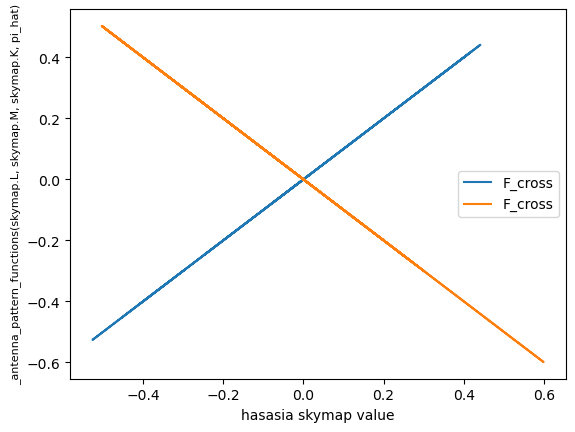

In [684]:
plt.plot(skymap.Fcross[:,0], F_icross3[:,0,0,0], label='F_cross')
plt.plot(skymap.Fplus[:,0], F_iplus3[:,0,0,0], label='F_cross')
plt.xlabel('hasasia skymap value')
plt.ylabel('_antenna_pattern_functions(skymap.L, skymap.M, skymap.K, pi_hat)', fontsize=8)
plt.legend()

## 4.5 Amplitude, A

$$ A = 2 \frac{G^{5/3} \mathcal{M}^{5/3} [\pi f [1+z]]^{2/3}}{c^4 r} \quad (5)$$
$ h = A\sqrt{\frac{1}{2}[a^2+b^2]} \quad (4)$ ?? a and b are defined by i, is that related to hc_ss then??
$$ h_s = \frac{8}{10^{1/2}} \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (2\pi f_r)^{2/3}  = \frac{2^{2/3}\times8}{2\times10^{1/2}} \times \big[ 2 \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (\pi f_r)^{2/3} \big] =  \frac{4(2)^{1/6}}{\sqrt{5}} A $$
$$ h_{c,ss}^2 = h_s^2 / dlnf = h_s^2 * f / df $$
$$ h_{c,ss} = h_s \sqrt{f/df} \frac{4(2)^{1/6}}{\sqrt{5}} A * f / df$$
$$ A = \frac{\sqrt{5}}{4 (2)^{1/6}} \sqrt{\frac{df}{f}} h_{c,ss} $$

In [685]:
def _amplitude(hc_ss, f, df):
    """ Calculate the amplitude from the single source to use in DP calculations
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of each single source at each realization.
    f : (F,) 1Darray
        Frequency
    df : (F,) 1Darray
        Frequency bin widths.

    Returns
    -------
    Amp : (F,R,L)
        Dimensionless amplitude, A, of each single source at each frequency and realization.
    
    """

    Amp = hc_ss * np.sqrt(5) / 4 / 2**(1/6) *np.sqrt(df[:,np.newaxis,np.newaxis]/f[:,np.newaxis,np.newaxis])
    return Amp

In [686]:
dfobs = np.diff(edges[-1])
amp = _amplitude(hc_ss, fobs, dfobs)
print(amp.shape, holo.utils.stats(amp))

(25, 30, 5) 2.39e-18, 5.17e-18, 8.03e-18, 2.25e-17, 9.61e-17, 2.00e-16, 1.17e-15


## 4.6 ss_noise
Noise from all other sources in the same frequency bin except for the loudest
$$ S_{h,\mathrm{rest}} = \frac{h_{c,\mathrm{rest}}^2}{f} \frac{1}{12 \pi^2 f^2} \quad\quad\quad(45)$$
Included in total noise spectral density for the ith pulsar
$$S_i = 2\Delta t \sigma_i^2 + S_{h,\mathrm{rest}}\quad\quad\quad(44)$$

In [687]:
def _Sh_rest_noise(hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density contribution from all but the current single source.

    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    ss_noise : (F,R,L) NDarray of scalars
        The noise in a single pulsar from other GW sources for detecting each single source.

    Follows Eq. (45) in Rosado et al. 2015.
    TODO: modify this to allow for multiple loud sources.
    """
    hc2_louds = np.sum(hc_ss**2, axis=2) # (F,R) 
    # subtract the single source from rest of loud sources and the background, for each single source
    hc2_rest = hc_bg[:,:,np.newaxis]**2 + hc2_louds[:,:,np.newaxis] - hc_ss**2 # (F,R,L)
    Sh_rest = hc2_rest / freqs[:,np.newaxis,np.newaxis]**3 /(12 * np.pi**2) # (F,R,L)
    return Sh_rest

# otherwise calculate from scratch
def _total_noise(delta_t, sigmas, hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density of each pulsar, s it pertains to single
    source detections, i.e., including the background as a noise source. 

    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigmas : (P,) 1Darray
        Variance for the ith pulsar, in seconds
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    noise : (P,F,R,L) NDarray of scalars
        The total noise in each pulsar for detecting each single source

    Follows Eq. (44) in Rosado et al. 2015.
    """

    noise = _white_noise(delta_t, sigmas) # (P,)
    Sh_rest = _Sh_rest_noise(hc_ss, hc_bg, freqs) # (F,R,L,)
    noise = noise[:,np.newaxis,np.newaxis,np.newaxis] + Sh_rest[np.newaxis,:,:,:] # (P,F,R,L)
    return noise

In [688]:
tot_noise = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)
print(tot_noise.shape, holo.utils.stats(tot_noise))

(20, 25, 30, 5) 1.26e-07, 1.26e-07, 1.26e-07, 1.26e-07, 1.41e-07, 6.21e-07, 1.39e-05


## 4.7 Polarization contributions
$$ a = 1 + \cos^2 \iota $$
$$ b = -2 \cos \iota $$

Where $\iota$ is the binary inclination angle.

In [689]:
def _a_b_polarization(iotas):
    """ Polarization contribution variables a and b.
    
    Parameters
    ----------
    iotas : scalar or NDarray
        Typically will be (F,R,L) NDarray

    Returns
    -------
    a_pol : scalar or NDarray
        Same shape as iota
    b_pol : scalar or NDarray
        Same shape as iota

    """
    a_pol = 1 + np.cos(iotas) **2
    b_pol = -2 * np.cos(iotas)
    return a_pol, b_pol

In [690]:
# ss_iotas = ss_psis
a_pol, b_pol = _a_b_polarization(ss_iotas)

## 4.8 GW Phase
$\Phi_0$ is the initial phase and describes the signal detected on Earth. $\Phi(t) = 2\pi f t$, and 
$$\Phi_T = 2 \pi f T \quad\quad\quad (47)$$ 
where $T$ is the duration. 

In [691]:
def _gw_phase(dur, freqs, Phi_0):
    """ Calculate the detected gravitational wave phase at each frequency.

    Parameters
    ----------
    dur : scalar
        Duration (time elapsed from initial phase to detection)
    freqs : (F,) 1Darray
        Frequency of each single source.
    Phi_0 : (F,R,L) NDarray
        Initial GW phase of each binary.

    Returns
    -------
    Phi_T : (F,R,L) NDarray
        Detected GW phase of each single source.
    """

    Phi_T = 2 * np.pi * freqs[:,np.newaxis,np.newaxis] * dur + Phi_0
    return Phi_T

## 4.9 SNR 
### 4.9.1 SNR for a single pulsar
$$ \mathrm{S/N}_i^2 = \frac{A^2}{S_i 8 \pi^3 f^3} \bigg[a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)]
+ \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] \\
+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] \\
- 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) 
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big]\bigg]\quad\quad\quad(46) $$

### 4.9.2 Total SNR (for each single source)
$$\mathrm{S/N_S} = \Big[ \sum_{i=1}^{M} \mathrm{S/N}_i^2\Big]^{1/2} \quad\quad\quad(35)$$

breaking up the SNR_i equation into pieces:
$$ \mathrm{Term 1} = a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)] + \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] $$
$$ \mathrm{Term 2} =+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] $$
$$\mathrm{Term 3} = - 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) \\
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big] $$

$$\mathrm{Coef} =  \frac{A^2}{S_i 8 \pi^3 f^3}$$
$$S/N_i^2 = \mathrm{Coef} \bigg[\mathrm{Term1} + \mathrm{Term2} + \mathrm{Term3}\bigg]$$

In [692]:
def _SNR_ss(amp, F_iplus, F_icross, iotas, dur, Phi_0, S_i, freqs):
    """ Calculate the SNR for each pulsar wrt each single source detection.

    Paramters
    ---------
    amp : (F,R,L) NDarray 
        Dimensionless strain amplitude for loudest source at each frequency.
    F_iplus : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    F_icross : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    iotas : (F,R,L) NDarray
        Is this inclination? or what?
        Gives the wave polarizations a and b.
    dur : scalar
        Duration of observations.
    Phi_0 : (F,R,L) NDarray
        Initial GW Phase.
    S_i : (P,F,R,L) NDarray
        Total noise of each pulsar wrt detection of each single source, in s^3
    freqs : (F,) 1Darray 

    Returns
    -------
    SNR_ss : (F,R,L) NDarray
        SNR from the whole PTA for each single source.

    """
    
    amp = amp[np.newaxis,:,:,:]  # (F,R,L) to (P,F,R,L)
    # print('amp', amp.shape)

    a_pol, b_pol = _a_b_polarization(iotas)
    a_pol = a_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    b_pol = b_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    # print('a_pol', a_pol.shape)
    # print('b_pol', b_pol.shape)

    Phi_T = _gw_phase(dur, freqs, Phi_0) # (F,R,L)
    # print('Phi_T', Phi_T.shape)
    Phi_T = Phi_T[np.newaxis,:,:,:] # (F,) to (P,F,R,L)
    # print('Phi_T', Phi_T.shape)

    Phi_0 = Phi_0[np.newaxis,:,:,:] # (P,F,R,L)
    # print('Phi_0', Phi_0.shape)

    freqs = freqs[np.newaxis,:,np.newaxis,np.newaxis] # (F,) to (P,F,R,L)
    # print('freqs', freqs.shape)

    coef = amp**2 / (S_i * 8 * np.pi**3 * freqs**3) # [S_i] s^3 and [freqs^3] Hz^3 cancel
    
    term1 = a_pol**2 * F_iplus**2 * (Phi_T * (1 + 2 * np.sin(Phi_0)**2) 
                                     + np.cos(Phi_T)*(-np.sin(Phi_T) + 4 * np.sin(Phi_0)) 
                                     - 4*np.sin(Phi_0))
    
    term2 = b_pol**2 * F_icross**2 * (Phi_T*(1+2*np.cos(Phi_0)**2) 
                                      + np.sin(Phi_T)*(np.cos(Phi_T) - 4 * np.cos(Phi_0)))
    
    term3 = - (2*a_pol*b_pol*F_iplus*F_icross 
               * (2*Phi_T*np.sin(Phi_0)*np.cos(Phi_0)
                  + np.sin(Phi_T)*(np.sin(Phi_T) - 2*np.sin(Phi_0) 
                                   + 2*np.cos(Phi_T)*np.cos(Phi_0) 
                                   - 2*np.cos(Phi_0))))
    
    SNR2_pulsar_ss = coef*(term1 + term2 + term3) # (P,F,R,L)

    SNR_ss = np.sqrt(np.sum(SNR2_pulsar_ss, axis=0)) # (F,R,L), sum over the pulsars
    return SNR_ss

In [693]:
SNR_ss = _SNR_ss(amp=amp, F_iplus=F_iplus, F_icross=F_icross, iotas=ss_iotas,
                 dur = dur, Phi_0=ss_Phi0s, S_i=tot_noise, freqs=fobs)
print(SNR_ss.shape, holo.utils.stats(SNR_ss))

(25, 30, 5) 6.96e-04, 2.49e-03, 4.58e-03, 2.06e-02, 2.23e-01, 5.14e-01, 3.43e+00


### 4.9.3 scDeter.SNR(h0)
Compare to hasasia DeterSensitivityCurve.
$$  \rho(\hat{n})=h_0\sqrt{\frac{T_{\rm obs}}{S_{\rm eff}(f_0 ,\hat{k})}} \quad\quad\quad(79) $$ 
from Hazboun et al. 2019.
This might be more comparable to my results if $S_\mathrm{eff}$ is replaced with the noise spectral density that I am using.




#### h0 strain amplitude

$$ S_h(f) \equiv \frac{1}{2} h_0^2 [ \delta(f-f_0) + \delta(f+f_0) ] \quad\quad(47)$$
When I'm using strains at specific frequencies, I think this is just:
$$ S_h(f) \equiv \frac{1}{2} (h_0(f))^2 $$

I could use that and $$h_c(f) \equiv \sqrt{f S_h(f)} \quad\quad(56)$$ 
to get $h_0$ from my $h_c$ by
$$h_0 = \sqrt{2 S_h(f)} = \sqrt{2 \frac{h_c(f)^2}{f}} = \sqrt{2} \frac{h_c(f)}{\sqrt{f}}$$
and plug that in to hasasia's scDeter.SNR which does $\mathrm{SNR} = h_0 \sqrt{\frac{T_\mathrm{span}}{S_\mathrm{eff}}}$

However I thought by definition
$$ h_c^2 df \equiv h_s^2 d\ln{f} \rightarrow \\
 h_c^2 df =  h_s^2 \frac{df}{f} \rightarrow \\
h_c^2 = \frac{h_s^2}{f} \rightarrow \\
 h_c(f) = \frac{h_s(f)}{\sqrt{f}}$$
or something like that. Idk the right way to write that first line, since I usually see it in an integral over some dlnf, but I'm confident(ish) in the last line.

#### hs to hc for single sources
$$ h_c^2 = h_s^2 f /df $$
$$ h_s = h_c \sqrt{\frac{df}{f}} $$

In [694]:
# Here we use the 0th realization, 0th loudest source
scDeter = hsen.DeterSensitivityCurve(spectra)
SNR_scdet = np.zeros_like(hc_ss)
hs = holo.utils.char_strain_to_strain_amp(hc_ss, fobs, df)
for rr in range(len(hc_ss[0])):
    for ll in range(len(hc_ss[0,0])):
        SNR_scdet[:,rr,ll] = scDeter.SNR(hs[:,rr,ll])
print(SNR_scdet.shape), holo.utils.stats(SNR_scdet)
print('SNR_ss of 0th realization, 0th loudest source:\n', SNR_ss[:,0,0])
print('SNR using hasasia:', SNR_scdet[:,0,0])

(25, 30, 5)
SNR_ss of 0th realization, 0th loudest source:
 [0.45939709 0.74466503 0.79052014 0.59804261 0.36991332 0.24610231
 0.68544507 0.23891412 0.07624561 0.05379653 0.03791086 0.02175821
 0.03477873 0.01393121 0.0122291  0.01069026 0.04805953 0.04707985
 0.03669919 0.01063646 0.01895452 0.00522969 0.00911396 0.00361368
 0.01228095]
SNR using hasasia: [2.33723974e+00 9.54243583e-01 6.35859681e-01 4.42994903e-01
 3.74153817e-01 2.00499002e-01 5.13334993e-01 1.39984450e-01
 3.76563990e-02 6.04981505e-17 5.47680530e-02 3.47247489e-02
 3.30035726e-02 2.09882676e-02 1.85686192e-02 1.04409785e-02
 3.37728037e-02 5.17734343e-02 2.39287220e-02 8.28468632e-03
 1.49456596e-02 3.88800829e-03 9.62013758e-03 6.24614945e-03
 7.03220337e-03]


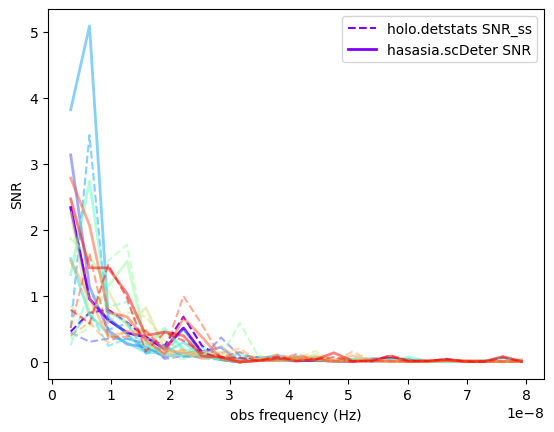

In [695]:
nreals = np.min([10, len(hc_ss[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))

plt.plot(fobs, SNR_ss[:,0,0], linestyle='--', color=colors[0], label='holo.detstats SNR_ss')
plt.plot(fobs, SNR_scdet[:,0,0], linestyle='solid', color=colors[0], label='hasasia.scDeter SNR', linewidth=2) # looks like actual SNR, not sensitivity

for rr in range(1, nreals):
    plt.plot(fobs, SNR_ss[:,rr,0], linestyle='--', alpha=0.5, color=colors[rr])
    plt.plot(fobs, SNR_scdet[:,rr,0], linestyle='solid', alpha=0.5, color=colors[rr], linewidth=2) # looks like actual SNR, not sensitivity

plt.xlabel('obs frequency (Hz)')
plt.ylabel('SNR')
plt.legend()

## 4.10 Threshold F-statistic $\cal{\bar{F}}_e$ 

Calculated from
$$ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N \quad\quad\quad(31)$$
where $\alpha_0$ is the fixed value false alarm probability and $N$ is the number of single sources (in that realization).

$$ 0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N - \alpha_0 $$
Note, this is the same across all realizations, since it just depends on the number of single sources.

In [696]:
# def _func_Fe_thresh(Fe_bar, Num, alpha_0):
#     # this is only needed for fsolve
#     rv =  1 - (1 - (1 + Fe_bar)*np.exp(-Fe_bar))**Num - alpha_0
#     return rv

# def _Fe_thresh_fsolve(Num, alpha_0=0.001):
#     """ Calculate the threshold F_e statistic using scipy.fsolve.
    
#     Parameters
#     ----------
#     Num : int
#         Number of single sources to detect.
#     alpha_0 : scalar
#         False alarm probability max.

#     Returns
#     -------
#     Fe_bar : scalar
#         Threshold Fe statistic

#     This function doesn't work.
#     """
    
#     Fe_bar = sp.optimize.fsolve(_func_Fe_thresh, 1, args=(Num, alpha_0))[0]
#     return Fe_bar

# import sympy

def _Fe_thresh(Num, alpha_0=0.001):
    """ Calculate the threshold F_e statistic using sympy.nsolve
    
    Parameters
    ----------
    Num : int
        Number of single sources to detect.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    Fe_bar : scalar
        Threshold Fe statistic
    """
    Fe_bar = sympy.Symbol('Fe_bar')
    func = 1 - (1 - (1 + Fe_bar)*np.e**(-Fe_bar))**Num - alpha_0
    Fe_bar = sympy.nsolve(func, Fe_bar, 10)
    return(Fe_bar)

From Wolfram Alpha, Num=25 should give Fe_bar=12.7, Num=125 should give Fe_bar = 14.47 (and many other values particularly -1, complex numbers, and 0)

In [697]:
Num = hc_ss[:,0,:].size # does not depend on realizations
print(Num)
Fe_bar = _Fe_thresh(Num)
print(Fe_bar)

125
14.4747847166094


## 4.11 Detection Probability
### 4.11.1 DP of one single source
$$\gamma_i = \int_{\cal{\bar{F}}_e}^\infty p_1(\cal{F}_e, \rho) d \cal{F}_e \\
= \int_{\cal{\bar{F}}_e}^\infty \frac{[2\cal{F}_e]^{1/2}}{\rho} I_1(\rho\sqrt{2\cal{F}_e}) e^{-\cal{F}_e-\frac{1}{2} \rho^2} d\cal{F}_e \quad\quad(32)$$
with $\rho=\mathrm{S/N_i}$ and $\cal{\bar{F}}_e$ calculated from $ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N$ where $N$ is the number of single sources (in that realization)


I should check this with a test case on Mathematica. On Wolfram alpha I tried: 

integrate sqrt(2* F)/rho * (modified bessel function of the first kind(rho * sqrt(2*F))) * exp(-F - 1/2 rho^2) dF from 14.47 to infinity for rho=0.66085444,

or

integrate sqrt(2*F)/0.66085444 * (modified bessel first kind(0.66085444 * sqrt(2*F))) * exp(-F - 1/2 *0.66085444^2) dF from 14.47 to infinity 

but this timed out. Need to try mathematica instead.

In [698]:
def _integrand_gamma_ss_i(Fe, rho):

    I_1 = sp.special.i1(rho*np.sqrt(2*Fe))
    rv = (2*Fe)**(1/2) /rho * I_1 * np.exp(-Fe - rho**2 /2)
    return rv

def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for-loops.
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi


def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for loops!
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi



In [699]:
gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss)
print(gamma_ssi.shape, holo.utils.stats(gamma_ssi))
print(gamma_ssi.shape, gamma_ssi[:,0,0]) 

(25, 30, 5) 8.00e-06, 8.00e-06, 8.00e-06, 8.02e-06, 9.42e-06, 1.72e-05, 5.50e-02
(25, 30, 5) [1.49723345e-05 3.28491554e-05 3.77374459e-05 2.14899068e-05
 1.22222959e-05 9.74211155e-06 2.75650358e-05 9.63666692e-06
 8.16234427e-06 8.08259288e-06 8.04296033e-06 8.01680071e-06
 8.03677651e-06 8.00922789e-06 8.00802114e-06 8.00706538e-06
 8.06668269e-06 8.06414658e-06 8.04050458e-06 8.00703429e-06
 8.01370577e-06 8.00470988e-06 8.00621947e-06 8.00432268e-06
 8.00805558e-06]


Try using the hasasia SNR's instead
But is this the actual SNR, or just the SNR sensitivity? Actual SNR - cuz it's a function of h0

In [700]:
# print(rho_h_ss.shape, rho_h_ss)
gamma_ssi_h = _gamma_ssi(Fe_bar=Fe_bar, rho=SNR_scdet)
print(gamma_ssi_h.shape, gamma_ssi_h[:,5,0])


gamma_ssi[0,23,0] is nan, setting to 0.
(25, 30, 5) [1.12202642e-03 4.90989481e-04 1.15225527e-04 3.88161388e-04
 1.01900811e-05 8.34958688e-06 8.31929313e-06 8.29418216e-06
 8.06714599e-06 8.00396889e-06 8.06321996e-06 8.01892232e-06
 8.04547346e-06 8.04042522e-06 8.02519209e-06 8.03102080e-06
 8.01372625e-06 8.01602547e-06 8.01536076e-06 8.00422731e-06
 8.00428424e-06 8.00436523e-06 8.01440982e-06 8.00505580e-06
 8.00432902e-06]


Text(0, 0.5, 'SNR')

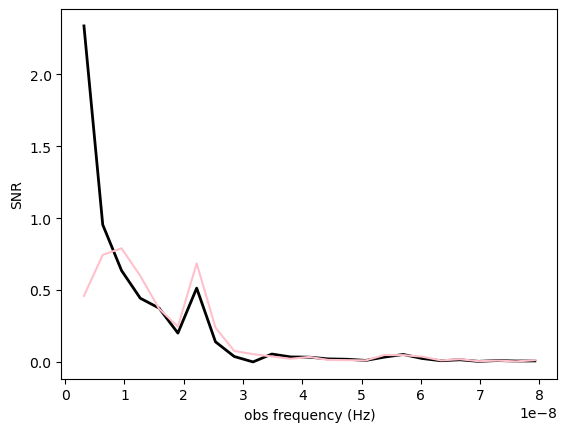

In [701]:
plt.plot(fobs, SNR_scdet[:,0,0], label='hasasia SNR', color='k', linewidth=2) # looks like actual SNR, not sensitivity
plt.plot(fobs, SNR_ss[:,0,0], color='pink', label='our SNR_ss, 0th loudest')
# for rr in range(len(hc_ss[0])):
#     plt.plot(fobs, SNR_ss[:,rr,0], color='pink', linestyle='--')
plt.xlabel('obs frequency (Hz)')
plt.ylabel('SNR')

In [702]:
print(hc_ss.shape)

(25, 30, 5)


Text(0, 0.5, 'SNR')

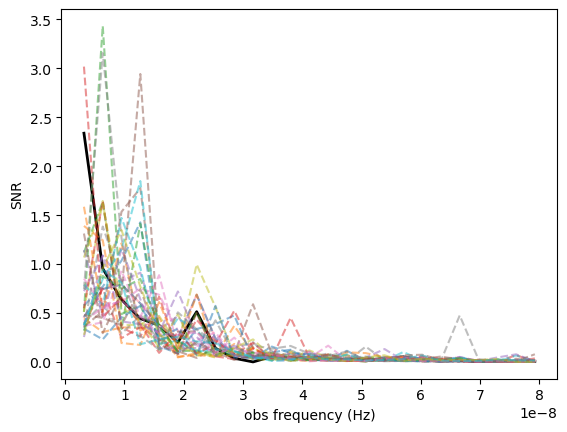

In [703]:
plt.plot(fobs, SNR_scdet[:,0,0], label='hasasia SNR', color='black', linewidth=2) # looks like actual SNR, not sensitivity
plt.plot(fobs, SNR_ss[:,0,0], color='pink', label='our SNR_ss, 0th loudest')
for rr in range(len(hc_ss[0])):
    plt.plot(fobs, SNR_ss[:,rr,0], linestyle='--', alpha=0.5)
plt.xlabel('obs frequency (Hz)')
plt.ylabel('SNR')

Why do I have one random nan value??

### 4.11.2 Detection Probability of any single source
$$\gamma_{ss} = 1 - \prod_{i}[1-\gamma_i]\quad\quad(33)$$

In [704]:
def _ss_detection_probability(gamma_ss_i):
    """ Calculate the probability of detecting any single source, given individual single 
    source detection probabilities.
    
    
    Parameters
    ----------
    gamma_ss_i : (F,R,L) NDarray
        Detection probability of each single source, at each frequency and realization.

    Returns
    -------
    gamma_ss : (R) 1Darray
        Detection probability of any single source, for each realization
    """
    
    gamma_ss = 1 - np.product(1-gamma_ss_i, axis=(0,2))
    return gamma_ss

In [705]:
gamma_ss = _ss_detection_probability(gamma_ssi)
print(gamma_ss.shape, holo.utils.stats(gamma_ss))
print(gamma_ss.squeeze())

(30,) 1.10e-03, 1.12e-03, 1.14e-03, 1.46e-03, 2.41e-03, 3.27e-02, 5.63e-02
[0.00118988 0.00114492 0.05629625 0.0011044  0.00127864 0.00244883
 0.00120349 0.00111717 0.00181177 0.00157341 0.00155967 0.00172986
 0.0020295  0.00176802 0.0013325  0.00112051 0.001178   0.00147857
 0.00178142 0.00231383 0.00111947 0.00153708 0.00118813 0.02424802
 0.00126747 0.02084416 0.00113196 0.03265732 0.0014416  0.00118958]


In [706]:
gamma_ss_h = _ss_detection_probability(gamma_ssi_h)
print(gamma_ss_h.shape, gamma_ss_h)

(30,) [0.00616327 0.03429329 0.56701449 0.00234735 0.01430907 0.00561365
 0.0071382  0.00196529 0.02398053 0.00886376 0.00316238 0.03579971
 0.03309664 0.00284172 0.4193385  0.00349927 0.00165679 0.0085171
 0.01107928 0.02019828 0.00216027 0.10297089 0.00309756 0.00270844
 0.00247035 0.04868523 0.0032485  0.02356754 0.00377697 0.00375816]


#### PLOT SNR and DP Hasasia Comparison

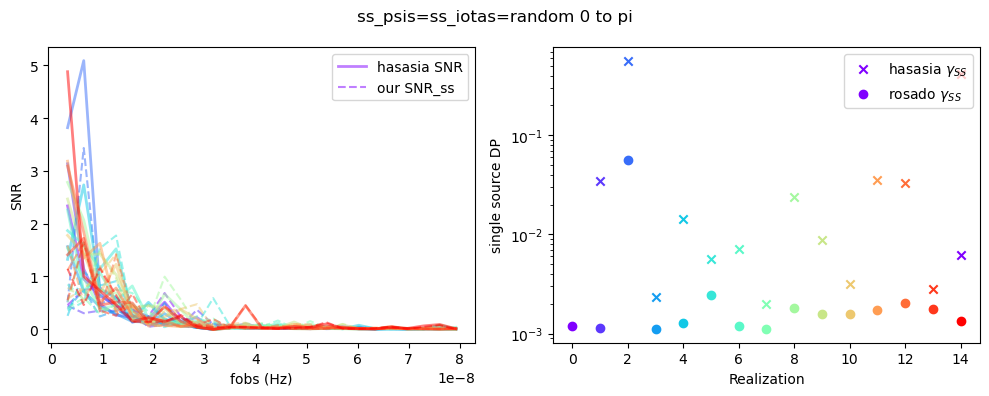

In [707]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
nreals=np.min([15, len(hc_ss[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
axs[0].plot(fobs, SNR_scdet[:,0,0], color=colors[0], linestyle='-', alpha=0.5, linewidth=2, label='hasasia SNR') # looks like actual SNR, not sensitivity
axs[0].plot(fobs, SNR_ss[:,0,0], color=colors[0], linestyle='--', alpha=0.5, label='our SNR_ss')
for rr in range(1, nreals):
    axs[0].plot(fobs, SNR_scdet[:,rr,0], linestyle='-', alpha=0.5, color=colors[rr], linewidth=2) # looks like actual SNR, not sensitivity
    axs[0].plot(fobs, SNR_ss[:,rr,0], linestyle='--', alpha=0.5, color = colors[rr])

    axs[1].scatter(rr, gamma_ss[rr], color = colors[rr],marker='o')
    axs[1].scatter(rr, gamma_ss_h[rr], color = colors[rr], marker='x')

axs[0].set_xlabel('fobs (Hz)')
axs[0].set_ylabel('SNR')
axs[0].legend()

axs[1].scatter(rr, gamma_ss_h[0], color = colors[0], marker='x', label='hasasia $\gamma_{SS}$')
axs[1].scatter(0, gamma_ss[0], color = colors[0], label='rosado $\gamma_{SS}$')
axs[1].set_ylabel('single source DP')
axs[1].set_xlabel('Realization')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')

fig.suptitle(label)
fig.tight_layout()

Several binaries have hasasia SNR's about an order of magnitude higher than the SNR's we calculated. That order of magnitude makes a big difference in the total detection probability!

In [708]:
def detect_ss(thetas, phis, sigmas, cad, dur, 
              fobs, dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False,
              theta_ss=None, phi_ss=None, iota_ss=None, psi_ss=None, Phi0_ss=None):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    thetas : (P,) 1Darray of scalars
        Polar (latitudinal) angular position of each pulsar in radians.
    phis : (P,) 1Darray of scalars
        Azimuthal (longitudinal) angular position of each pulsar in radians.
    sigmas : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    psi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """

    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if psi_ss is None:
        psi_ss = iota_ss # edit this when I figure out what psi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



In [709]:

def detect_ss_pta(pulsars, cad, dur, fobs,
              dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray
        Frequency bin centers (in Hz).
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    psi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """
    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if psi_ss is None:
        psi_ss = iota_ss # edit this when I figure out what psi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)


     # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = np.mean(pulsars[ii].toaerrs)

    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



In [721]:
def detect_ss_scDeter(pulsars, scDeter, fobs,
              dfobs, hc_ss, alpha_0=0.001, ret_SNR=False,
              theta_ss=None, phi_ss=None, iota_ss=None, psi_ss=None, Phi0_ss=None):
    """ (BUGS) Calculate the single source detection probability using scDeter object.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    scDeter : hasasia.sensitivity.DeterSensitivityCurve object
        Deterministic sensitivity curve from hasasia.
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in Hz.
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in Hz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_SNR : Bool
        Whether or not to also return SNR_ss.
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
    psi_ss : (F,R,L) NDarray or None
        Polarization angle.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.
    rho_h_ss: (F,R,L) NDarray
        SNR of each single source.

    TODO: Need to fix SNR(h0) calculation. It currently uses hc_ss instead.
    """

    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = np.mean(pulsars[ii].toaerrs)

    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if psi_ss is None:
        psi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss.size).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, psi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # rho_ss (corresponds to SNR)
    hs = holo.utils.char_strain_to_strain_amp(hc_ss, fobs, dfobs)
    rho_h_ss = np.zeros(hc_ss.shape) # (F,R,L)
    for rr in range(len(hc_ss[0])):
        for ll in range(len(hc_ss[0,0])):
            rho_h_ss[:,rr,ll] =   scDeter.SNR(hs[:,rr,ll]) 
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num, alpha_0=alpha_0) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=rho_h_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_SNR:
        return gamma_ss, rho_h_ss,
    else:
        return gamma_ss

In [728]:
gamma_ss3, SNR_ss3 = detect_ss_scDeter(pulsars, scDeter, fobs, dfobs, hc_ss, ret_SNR=True)
print(gamma_ss3.shape, gamma_ss3) #large variation between realizations!

gamma_ssi[0,23,0] is nan, setting to 0.
(30,) [0.00616327 0.03429329 0.56701449 0.00234735 0.01430907 0.00561365
 0.0071382  0.00196529 0.02398053 0.00886376 0.00316238 0.03579971
 0.03309664 0.00284172 0.4193385  0.00349927 0.00165679 0.0085171
 0.01107928 0.02019828 0.00216027 0.10297089 0.00309756 0.00270844
 0.00247035 0.04868523 0.0032485  0.02356754 0.00377697 0.00375816]


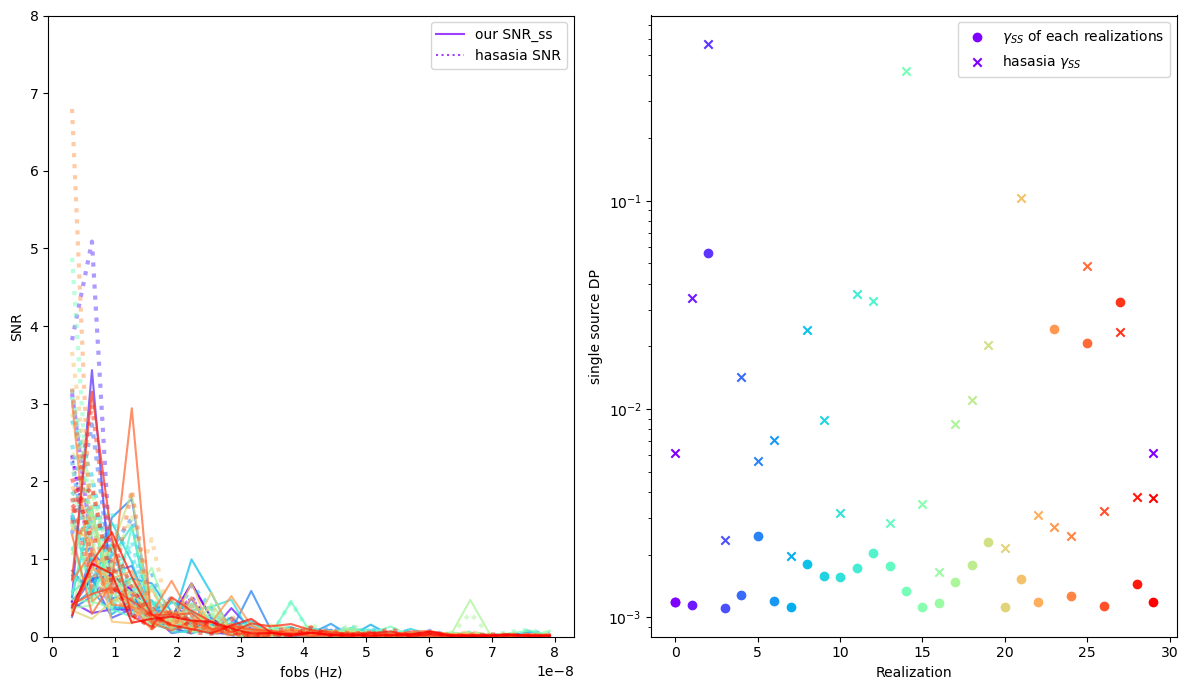

In [731]:
fig, axs = plt.subplots(1,2, figsize=(12,7))
colors = cm.rainbow(np.linspace(0,1,len(hc_ss[0])))
axs[0].plot(fobs, SNR_ss[:,0,0], linestyle='-', alpha=0.75, color=colors[0], label='our SNR_ss')
axs[0].plot(fobs, SNR_ss3[:,0,0], linestyle='dotted', alpha=0.75, color = colors[0], label='hasasia SNR', )
for rr in range(len(hc_ss[0])):
    axs[0].plot(fobs, SNR_ss[:,rr,0], linestyle='-', alpha=0.75, color = colors[rr])
    axs[0].plot(fobs, SNR_ss3[:,rr,0], linestyle='dotted', alpha=0.5, linewidth=3, color = colors[rr])
axs[0].set_xlabel('fobs (Hz)')
axs[0].set_ylabel('SNR')
# axs[0].set_yscale('log')
axs[0].set_ylim(0,8)
axs[0].legend()

axs[1].scatter(0, gamma_ss[0], color = colors[0], label='$\gamma_{SS}$ of each realizations')
axs[1].scatter(rr, gamma_ss3[0], color = colors[0], marker='x', label = 'hasasia $\gamma_{SS}$')
for rr in range(len(hc_ss[0])):
    axs[1].scatter(rr, gamma_ss[rr], color = colors[rr])
    axs[1].scatter(rr, gamma_ss3[rr], color = colors[rr], marker='x')
axs[1].set_ylabel('single source DP')
axs[1].set_xlabel('Realization')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')
fig.tight_layout()

I should also compare S_i to hasasia?

# Fraction Detected

In [732]:
def fraction_detected(hc_ss, hc_bg, scDeter, scGWB):
    """ Find the fraction of realizations that have a strain detectable by 
    a PTA with the given sensitivity curves.
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of the single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain of the gw background.
    scDeter : hasasia.sensitivity.DeterSensitivityCurve Object
        Sensitivity curve for deterministic (single) sources.
    scGWB : hasasia.sensitivity.GWBSensitivityCurve Object
        Sensitivity curve for the GWB.
    
    Returns
    -------
    frac_ss : (F,) 1Darray
        Fraction of realizations with an ss strain above the deterministic sensitivity
         curve at each frequency
    frac_ss_any : scalar
        Fraction of realization with any ss detection
    frac_bg : (F,) 1Darray
        Fraction of realizations with the bg strain above the GWB sensitivity 
        curve at each frequency
    frac_bg_any : scalar
        Fraction of realizations with the bg strain above the GWB sensitivity
        curve at any frequency.  

    I'm not sure if this makes sense, particularly for the background. Would
    we have a background detection if it's above the sensitivity curve at at 
    least one frequency?
    """

def fraction_ss_detected(hc_ss, hc_ss_sens):
    """ Find the fraction of realizations that have a strain detectable by 
    a PTA with the given sensitivity curves.
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of the single sources.
    hc_ss_sens : (F,) 1Darray
        Characteristic strain sensitivity (scDeter.h_c).
    
    Returns
    -------
    frac_ss : (F,) 1Darray
        Fraction of realizations with an ss strain above the deterministic sensitivity
         curve at each frequency
    frac_ss_any : scalar
        Fraction of realization with any ss detection

    I think this makes more sense.
    """
    # I can do this faster with ndars, but here's a simple loops method 

    count_freq = np.zeros(len(hc_ss)) # (F,)
    count_any = 0
    for rr in range(len(hc_ss[0])):
        if np.any(hc_ss[:,rr,0]>=hc_ss_sens):
            count_any += 1
        for ff in range(len(hc_ss)):
            if (hc_ss[ff,rr,0] >= hc_ss_sens[ff]): # only need to test the single loudest
                count_freq[ff] += 1
    frac_ss = count_freq/len(hc_ss[0])
    frac_ss_any = count_any/len(hc_ss[0])

    return frac_ss, frac_ss_any

In [733]:
hc_ss_sens = scDeter.h_c
frac_ss, frac_ss_any = fraction_ss_detected(hc_ss, hc_ss_sens)
print(frac_ss)
print(frac_ss_any)

[1.         0.93333333 0.4        0.23333333 0.06666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
1.0


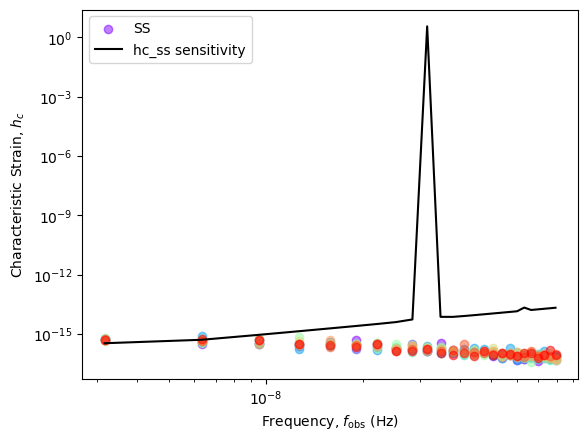

In [734]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (Hz)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_ss = 'SS'
    else:
        label_ss = None
    plt.scatter(fobs, hc_ss[:,rr,ll], alpha=0.5, label=label_ss,
                color=colors[rr])
# plt.loglog(fobs, np.median(hc_bg, axis=1), color='gray', label='median GWB')

plt.loglog(fobs, hc_ss_sens, color='k', label='hc_ss sensitivity')
plt.legend()


It does look like here, every realization has at least one single source above the sensitivity curve at the lowest frequency.